## Оптимизация выполнения кода, векторизация, Numba

Материалы:
* Макрушин С.В. Лекция 3: Оптимизация выполнения кода, векторизация, Numba
* IPython Cookbook, Second Edition (2018), глава 4
* https://numba.pydata.org/numba-doc/latest/user/5minguide.html

In [10]:
#!pip3 install line_profiler
%load_ext line_profiler

## Задачи для совместного разбора

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`.

In [1]:
import numpy as np
A = np.random.randint(0,1000,1000000)
A

array([910, 710,  34, ..., 225, 144, 608])

In [2]:
def f1(A):
    acc,cnt = 0,0
    for ai in A:
        bi = ai + 100
        acc+= bi
        cnt+=1
    return acc/cnt

In [3]:
%timeit f1(A)

251 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%lprun -f f1 f1(A)

In [12]:
def f2(A):
    acc = 0
    for ai in A:
        bi = ai + 100
        acc+= bi
        
    return acc/len(A)

In [13]:
%lprun -f f2 f2(A)

In [14]:
def f3(A):
    acc = 0
    for ai in A:
        
        acc+= ai
        
    return acc/len(A) + 100

In [16]:
%lprun -f f3 f3(A)

In [17]:
%timeit f3(A)

93.6 ms ± 600 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit np.mean(A)

524 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
import numba

In [20]:
@numba.njit
def f5(A):
    acc,cnt = 0,0
    for ai in A:
        bi = ai + 100
        acc+= bi
        cnt+=1
    return acc/cnt
    
f5(A)   

599.744746

In [21]:
%timeit f5(A)

330 µs ± 2.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


2. Создайте таблицу 2млн строк и с 4 столбцами, заполненными случайными числами. Добавьте столбец `key`, которые содержит элементы из множества английских букв. Выберите из таблицы подмножество строк, для которых в столбце `key` указаны первые 5 английских букв.

In [22]:
import pandas as pd
df = pd.DataFrame( np.random.randint(0,1000,size = (2000000,4)),columns = ['col1','col2','col3','col4'])
letters = ['a','b','c','d','e','f','g','h']
df['key'] = np.random.choice(letters,2000000,replace = True)
df.head()

,col1,col2,col3,col4,key
0,922,151,564,167,e
1,105,217,246,401,b
2,885,38,684,887,c
3,21,875,362,630,h
4,803,872,287,884,h


In [23]:
def g(df):
    letters = ['a','b','c','d','e']
    dfs = []
    for letter in letters:
        q = df[df['key']==letter]
        dfs.append(q)
    return pd.concat(dfs,axis = 0)

In [24]:
%timeit g(df)

552 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%lprun -f g g(df)

In [26]:
%timeit df[df['key'].isin(['a','b','c','d','e'])] #средствами pandas

86.1 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Лабораторная работа 3

- 1. В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

Реализуйте несколько вариантов функции подсчета среднего значения столбца `rating` из таблицы `reviews` для отзывов, оставленных в 2010 году.

A. С использованием метода `DataFrame.iterrows` исходной таблицы;

Б. С использованием метода `DataFrame.iterrows` таблицы, в которой сохранены только отзывы за 2010 год;

В. С использованием метода `Series.mean`.

Проверьте, что результаты работы всех написанных функций корректны и совпадают. Измерьте выполнения всех написанных функций.


In [33]:
import pandas as pd
recipes = pd.read_csv('recipes_sample.csv', sep = ',', header = 0, parse_dates = ['submitted'])
reviews = pd.read_csv('reviews_sample.csv', sep = ',', header = 0, parse_dates = ['date'], index_col=0)
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            30000 non-null  object        
 1   id              30000 non-null  int64         
 2   minutes         30000 non-null  int64         
 3   contributor_id  30000 non-null  int64         
 4   submitted       30000 non-null  datetime64[ns]
 5   n_steps         18810 non-null  float64       
 6   description     29377 non-null  object        
 7   n_ingredients   21120 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.8+ MB


In [35]:
recipes.iterrows()

<generator object DataFrame.iterrows at 0x7fe98cce2900>

In [45]:
def A_mean(df):
    c = 0
    s = 0
    for row in df.iterrows():
        if row[1]['date'].year == 2010:
            s += row[1]['rating']
            c += 1
    return s/c

A_mean(reviews)

4.4544402182900615

In [49]:
%timeit A_mean(reviews)

4.55 s ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
def B_mean(df):
    c = 0
    s = 0
    for row in df[df['date'].dt.year == 2010].iterrows():
        s += row[1]['rating']
        c += 1
    return s/c

B_mean(reviews)

4.4544402182900615

In [51]:
%timeit B_mean(reviews)

439 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
def C_mean(df):
    return df[df['date'].dt.year == 2010]['rating'].mean()

C_mean(reviews)

4.4544402182900615

In [52]:
%timeit C_mean(reviews)

6.35 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- 2. Какая из созданных функций выполняется медленнее? Что наиболее сильно влияет на скорость выполнения? Для ответа использовать профайлер `line_profiler`. Сохраните результаты работы профайлера в отдельную текстовую ячейку и прокомментируйте результаты его работы.

(*). Сможете ли вы ускорить работу функции 1Б, отказавшись от использования метода `iterrows`, но не используя метод `mean`?

In [53]:
%lprun -f A_mean A_mean(reviews)

Timer unit: 1e-06 s

Total time: 19.3962 s
File: <ipython-input-45-b3e9d722b2e8>
Function: A_mean at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def A_mean(df):
     2         1        170.0    170.0      0.0      c = 0
     3         1          1.0      1.0      0.0      s = 0
     4    126697   18042526.0    142.4     93.0      for row in df.iterrows():
     5    126696    1246195.0      9.8      6.4          if row[1]['date'].year == 2010:
     6     12094     102812.0      8.5      0.5              s += row[1]['rating']
     7     12094       4539.0      0.4      0.0              c += 1
     8         1          1.0      1.0      0.0      return s/c

In [55]:
%lprun -f B_mean B_mean(reviews)

Timer unit: 1e-06 s

Total time: 1.87533 s
File: <ipython-input-46-b6206947181f>
Function: B_mean at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def B_mean(df):
     2         1          6.0      6.0      0.0      c = 0
     3         1          1.0      1.0      0.0      s = 0
     4     12095    1751280.0    144.8     93.4      for row in df[df['date'].dt.year == 2010].iterrows():
     5     12094     119792.0      9.9      6.4          s += row[1]['rating']
     6     12094       4247.0      0.4      0.2          c += 1
     7         1          1.0      1.0      0.0      return s/c

In [56]:
%lprun -f C_mean C_mean(reviews)

Timer unit: 1e-06 s

Total time: 0.022438 s
File: <ipython-input-48-a1800a6ecb6d>
Function: C_mean at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def C_mean(df):
     2         1      22438.0  22438.0    100.0      return df[df['date'].dt.year == 2010]['rating'].mean()

In [57]:
### больше всего код утяжеляют одни и те же вычисления (частое использование циклов) и лишнее присвоение значений переменным

In [61]:
def B_mean_new(df):
    dt = df[df['date'].dt.year == 2010]
    return dt['rating'].sum() / dt.shape[0]

B_mean_new(reviews)

4.4544402182900615

In [64]:
%timeit B_mean_new(reviews)

6.4 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
%lprun -f B_mean_new B_mean_new(reviews)

Timer unit: 1e-06 s

Total time: 0.007657 s
File: <ipython-input-61-2d0c9aaf3202>
Function: B_mean_new at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def B_mean_new(df):
     2         1       7341.0   7341.0     95.9      dt = df[df['date'].dt.year == 2010]
     3         1        316.0    316.0      4.1      return dt['rating'].sum() / dt.shape[0]

 - 3. Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержат то или иное слово. Измерьте время выполнения этой функции. Сможете ли вы найти узкие места в коде, используя профайлер? Выпишите (словами), что в имеющемся коде реализовано неоптимально. Оптимизируйте функцию и добейтесь значительного (как минимум, на один порядок) прироста в скорости выполнения.

In [112]:
def get_word_reviews_count(df):
    word_reviews = {}
    for _, row in df.dropna(subset=['review']).iterrows():
        recipe_id, review = row['recipe_id'], row['review']
        words = review.split(' ')
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)
    
    word_reviews_count = {}
    for _, row in df.dropna(subset=['review']).iterrows():
        review = row['review']
        words = review.split(' ')
        for word in words:
            word_reviews_count[word] = len(word_reviews[word])
    return word_reviews_count

In [115]:
get_word_reviews_count(reviews)

{'Last': 94,
 'week': 804,
 'whole': 5628,
 'sides': 312,
 'of': 109029,
 'frozen': 2647,
 'salmon': 729,
 'fillet': 60,
 'was': 88781,
 'on': 34583,
 'sale': 149,
 'in': 61539,
 'my': 44144,
 'local': 561,
 'supermarket,': 10,
 'so': 46090,
 'I': 285147,
 'bought': 1369,
 'tons': 161,
 '(okay,': 5,
 'only': 13965,
 '3,': 48,
 'but': 42513,
 'total': 381,
 'weight': 160,
 'over': 9065,
 '10': 2303,
 'pounds).': 2,
 '': 214145,
 'This': 39448,
 'recipe': 41098,
 'is': 55075,
 'perfect': 4398,
 'for': 121224,
 'fillet,': 14,
 'even': 7878,
 'though': 2314,
 'it': 111175,
 'calls': 520,
 'steaks.': 93,
 'cut': 6688,
 'up': 13585,
 'the': 266050,
 'into': 7031,
 'individual': 314,
 'portions': 156,
 'and': 217849,
 'followed': 4859,
 'instructions': 731,
 'exactly.': 571,
 "I'm": 7145,
 'one': 15086,
 'those': 2287,
 'food': 2413,
 'combining': 74,
 'diets,': 5,
 'left': 4690,
 'out': 23644,
 'white': 3425,
 'wine': 1256,
 'added': 21710,
 'just': 24944,
 'a': 166136,
 'dash': 532,
 'vineg

In [113]:
%timeit get_word_reviews_count(reviews)

12.3 s ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
%lprun -f get_word_reviews_count get_word_reviews_count(reviews)

Timer unit: 1e-06 s

Total time: 56.8805 s
File: <ipython-input-112-b1bc049bcd0c>
Function: get_word_reviews_count at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def get_word_reviews_count(df):
     2         1          1.0      1.0      0.0      word_reviews = {}
     3    126680   18471655.0    145.8     32.5      for _, row in df.dropna(subset=['review']).iterrows():
     4    126679    2327397.0     18.4      4.1          recipe_id, review = row['recipe_id'], row['review']
     5    126679     378740.0      3.0      0.7          words = review.split(' ')
     6   6918689    2554528.0      0.4      4.5          for word in words:
     7   6792010    3172494.0      0.5      5.6              if word not in word_reviews:
     8    174944      82860.0      0.5      0.1                  word_reviews[word] = []
     9   6792010    3479006.0      0.5      6.1              word_reviews[word].append(recipe_id)
    10                                               
    11         1          1.0      1.0      0.0      word_reviews_count = {}
    12    126680   18109903.0    143.0     31.8      for _, row in df.dropna(subset=['review']).iterrows():
    13    126679    1284246.0     10.1      2.3          review = row['review']
    14    126679     387882.0      3.1      0.7          words = review.split(' ')
    15   6918689    2578924.0      0.4      4.5          for word in words:
    16   6792010    4052818.0      0.6      7.1              word_reviews_count[word] = len(word_reviews[word])
    17         1          2.0      2.0      0.0      return word_reviews_count

In [117]:
# тяжелый "лишний" цикл for 
# лишний словарь

In [122]:
def get_word_reviews_count_new(df):
    word_reviews_count = {}
    for _, row in df.dropna(subset=['review']).iterrows():
        for word in row['review'].split(' '):
            if word not in word_reviews_count:
                word_reviews_count[word] = 0
            word_reviews_count[word] += 1 
    return word_reviews_count

In [123]:
get_word_reviews_count_new(reviews)

{'Last': 94,
 'week': 804,
 'whole': 5628,
 'sides': 312,
 'of': 109029,
 'frozen': 2647,
 'salmon': 729,
 'fillet': 60,
 'was': 88781,
 'on': 34583,
 'sale': 149,
 'in': 61539,
 'my': 44144,
 'local': 561,
 'supermarket,': 10,
 'so': 46090,
 'I': 285147,
 'bought': 1369,
 'tons': 161,
 '(okay,': 5,
 'only': 13965,
 '3,': 48,
 'but': 42513,
 'total': 381,
 'weight': 160,
 'over': 9065,
 '10': 2303,
 'pounds).': 2,
 '': 214145,
 'This': 39448,
 'recipe': 41098,
 'is': 55075,
 'perfect': 4398,
 'for': 121224,
 'fillet,': 14,
 'even': 7878,
 'though': 2314,
 'it': 111175,
 'calls': 520,
 'steaks.': 93,
 'cut': 6688,
 'up': 13585,
 'the': 266050,
 'into': 7031,
 'individual': 314,
 'portions': 156,
 'and': 217849,
 'followed': 4859,
 'instructions': 731,
 'exactly.': 571,
 "I'm": 7145,
 'one': 15086,
 'those': 2287,
 'food': 2413,
 'combining': 74,
 'diets,': 5,
 'left': 4690,
 'out': 23644,
 'white': 3425,
 'wine': 1256,
 'added': 21710,
 'just': 24944,
 'a': 166136,
 'dash': 532,
 'vineg

In [125]:
%timeit get_word_reviews_count_new(reviews)

5.89 s ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [126]:
%lprun -f get_word_reviews_count_new get_word_reviews_count_new(reviews)

 - 4. Напишите несколько версий функции `MAPE` (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от среднего значения рейтинга по всем отзывам для этого рецепта. 
    1. Без использования векторизованных операций и методов массивов `numpy` и без использования `numba`
    2. Без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`
    3. С использованием векторизованных операций и методов массивов `numpy`, но без использования `numba`
    4. C использованием векторизованных операций и методов массивов `numpy` и `numba`
    
Измерьте время выполнения каждой из реализаций.

Замечание: удалите из выборки отзывы с нулевым рейтингом.


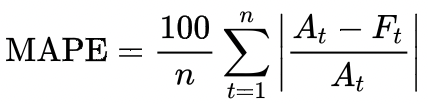

In [66]:
reviews_ = reviews[reviews['rating']!= 0].dropna(subset = ['rating'])

In [68]:
def A_MAPE(df):
    c = 0
    s = 0
    E = 0
    for val in df['rating']:
        s += val
        c += 1
    Ft = s/c
    for row in df['rating']:
        E += abs((row - Ft)/row)
    return (100/c) * E
        
A_MAPE(reviews_)    

16.266663338761624

In [69]:
%timeit A_MAPE(reviews_) 

30 ms ± 82.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
reviews_rating_ind = list(reviews_['rating'])

In [97]:
@numba.njit
def B_MAPE(df):
    c = 0
    s = 0
    E = 0
    for val in df:
        s += val
        c += 1
    Ft = s/c
    for val in df:
        E += abs((val - Ft)/val)
    return (100/c) * E
        
B_MAPE(reviews_rating_ind)   

/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'df' of function 'B_MAPE'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-97-f6063e3a6be8>", line 2:
@numba.njit
def B_MAPE(df):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


16.266663338761624

In [98]:
%timeit B_MAPE(reviews_rating_ind)

123 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
def C_MAPE(df):
    return (100/len(df['rating'])) * np.sum(np.abs((df['rating'] - np.mean(df['rating'])) / df['rating']))

C_MAPE(reviews_)

16.266663338799717

In [90]:
%timeit C_MAPE(reviews_)

707 µs ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
reviews_rating_ind_np = np.array(reviews_['rating'])

In [106]:
@numba.njit
def D_MAPE(df):
    return (100/len(df)) * np.sum(np.abs((df - np.mean(df)) / df))
                                
D_MAPE(reviews_rating_ind_np)

16.266663338761624

In [107]:
%timeit D_MAPE(reviews_rating_ind_np)

279 µs ± 178 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
